In [105]:
import sys
sys.path.append("..")
import datetime

from src.helper import make_ts

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

## 3.1 Simple forecasting methods

### Average Method:

The forecasts of all future values are equal to the average of the historical data:


$\hat{y}_{T+h|T}=\bar{y}=(y_{1}+..+y_{T})/T$

In [106]:
ts_df = make_ts('2000',20)

In [107]:
ts_df.head()

,Observation
Date,
2000-01-01,34.700778
2001-01-01,24.293396
2002-01-01,54.193494
2003-01-01,86.065211
2004-01-01,75.173669


In [108]:
def average_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(
                                        str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    ts['Forecast_AVG'] = y['Observation'].mean()
    ts.set_index('Date', inplace = True)
    return ts

In [109]:
forecast_avg = average_forecast(ts_df, 10)

## Naïve method

The forecasts of all future values are equal to the average of the historical data:


$\hat{y}_{T+h|T}=y_{T}$

In [229]:
def naive_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(
                                        str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    ts['Forecast_Naive'] = y['Observation'][-1]
    ## TODO: Incorporate shift into function to generalize
    ts.set_index('Date', inplace = True)
    return ts

In [111]:
forecast_naive = naive_forecast(ts_df, 10)

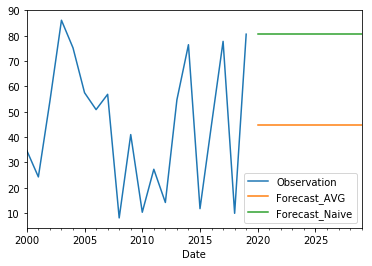

In [112]:
fig, ax = plt.subplots()
ts_df.plot(ax = ax)
forecast_avg.plot(ax = ax)
forecast_naive.plot(ax=ax)

In [113]:
seasonal = make_ts("2000", 12*20, 'M')

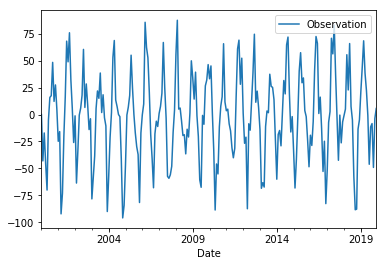

In [114]:
seasonal.plot()

In [115]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [121]:
def s_naive_forecast(y, h):
    """
    y = time series index of pandas data frame
    h = forecast horizon
    
    TODO: Move to helper.py. 
    """
    ts = pd.DataFrame(pd.date_range(str(ts_df.index[-1] + datetime.timedelta(days=365)), 
                                        periods = h, 
                                        freq=pd.infer_freq(y.index)
                                        ), 
                      columns = ['Date']
                     )
    history = [x for x in y['Observation']]
    prediction = []
    
    for i in range(h):
        predict = float(SARIMAX(history,
                            order = (0,0,0),
                            seasonal_order=(0,1,0,12)).fit(disp=0).forecast()[0]
                       )
    
        history.append(predict)
        prediction.append(predict)
    prediction = pd.Series(prediction)
    ts = pd.concat((ts,prediction), axis = 1)
    ts.columns = ['Date', 'Forecast']
    ts.set_index('Date', inplace = True)
    return ts

In [122]:
s_naive = s_naive_forecast(seasonal, 12*5)

C:\Users\rhall\AppData\Local\Continuum\anaconda3\envs\tswalk\lib\site-packages\statsmodels\tsa\statespace\representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]


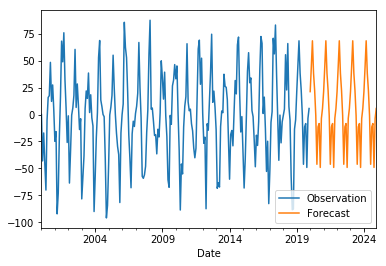

In [123]:
fig, ax = plt.subplots()
seasonal.plot(ax = ax)
s_naive.plot(ax = ax)

## 3.2 Transfomations and Adjustments

#### Python datetime curioisty

In [124]:
datetime.datetime.strptime('31-Dec-68', '%d-%b-%y').date()

datetime.date(2068, 12, 31)

In [125]:
datetime.datetime.strptime('1-Jan-69', '%d-%b-%y').date()

datetime.date(1969, 1, 1)

Python has a rollover in datetime where if the year is YY then before 69 is assumed to be 20YY while if YY is 69 or later it is assumed to be 19YY.
See more: https://stackoverflow.com/questions/37766353/pandas-to-datetime-parsing-wrong-year?answertab=votes#tab-top

#### Calendar Adjustments

In [126]:
milk = pd.read_csv("../data/milk.csv")

In [127]:
milk['index'] = pd.to_datetime(milk['index'])

In [128]:
milk['days']= milk['index'].dt.daysinmonth

In [129]:
milk.set_index('index', inplace = True)

In [130]:
milk['daily_average'] = milk['value']/milk['days']

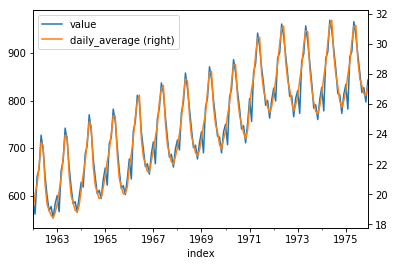

In [131]:
milk[['value', 'daily_average']].plot(secondary_y = ['daily_average'])

## Mathematical Transformations

#### Box-Cox transformations

Box-cox is useful for transforming data so it is closer to normal

$
  w_{t}=\begin{cases}
              \ln{y_{t}} & \text{if } \lambda \text{ = 0};\\
               \dfrac{(y_{t}^{\lambda} - 1)}{\lambda} & \text{otherwise};
            \end{cases}
$

where $w_{t}$ is the transformed data

In [132]:
from scipy import stats

In [133]:
elec = pd.read_csv("../data/elec.csv")

In [134]:
elec.head()

,index,value
0,1/1/1956,1254
1,2/1/1956,1290
2,3/1/1956,1379
3,4/1/1956,1346
4,5/1/1956,1535


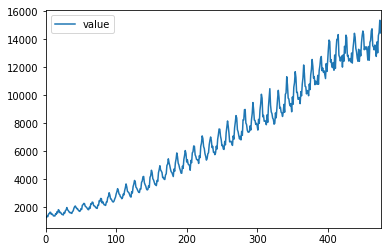

In [135]:
elec.plot()

In [136]:
elec['transformed'], lmbda = stats.boxcox(elec['value'])

In [137]:
elec['index'] = pd.to_datetime(elec['index'])

In [138]:
elec.set_index('index', inplace = True)

Value transformed with box-cox transformation with lambda = 0.3896252474492478


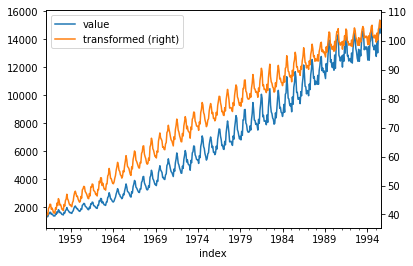

In [139]:
elec.plot(secondary_y = ['transformed'])
print('Value transformed with box-cox transformation with lambda = {}'.format(lmbda))

We can visually show the max lambda using the box-cox normality plot

Value transformed with box-cox transformation with max lambda = 0.3896252474492478


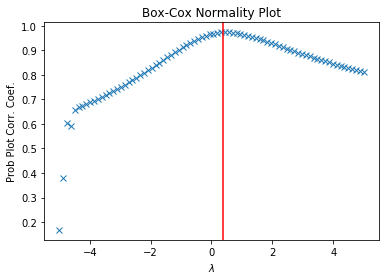

In [140]:
fig = plt.figure()
ax = fig.add_subplot(111)
prob = stats.boxcox_normplot(elec['value'], -5, 5, plot = ax)
_, maxlog = stats.boxcox(elec['value'])
ax.axvline(maxlog, color='r')
print('Value transformed with box-cox transformation with max lambda = {}'.format(maxlog))
plt.show()

#### Inverse Box-Cox

Inverse Box-Cox:
$
  y_{t}=\begin{cases}
               exp(w_{t}) & \text{if } \lambda \text{ = 0};\\
               (\lambda w_{t} + 1)^{(1/\lambda)} & \text{otherwise};
            \end{cases}
$

where $w_{t}$ is the transformed data

In [141]:
from scipy.special import boxcox, inv_boxcox

Note: scipy.special provides universal functions for almost all stats/functions/error functions/etc.

You can also give it a special kick using cython. cimport scipy.special.cython_special

See more here: https://docs.scipy.org/doc/scipy/reference/special.html

In [142]:
elec.head()

,value,transformed
index,,
1956-01-01,1254,38.788415
1956-02-01,1290,39.246996
1956-03-01,1379,40.348164
1956-04-01,1346,39.945072
1956-05-01,1535,42.178087


In [143]:
## using previous equations in BoxCox and lambda
elec['tback']= inv_boxcox(elec['transformed'], lmbda)

In [144]:
elec.head()

,value,transformed,tback
index,,,
1956-01-01,1254,38.788415,1254.0
1956-02-01,1290,39.246996,1290.0
1956-03-01,1379,40.348164,1379.0
1956-04-01,1346,39.945072,1346.0
1956-05-01,1535,42.178087,1535.0


### TODO: Find bias adjustment of Box-Cox. 

It could be a different name or there might not be a function made. If there is not one then make one

## 3.3 Residual diagnostics

### Fitted values

$\hat{y}_{t|t-1} = \hat{y}_{t}  \text{ by convention}$


For the average method:

$\hat{y}_{t} = \hat{c}$

For the drift method:

$\hat{y}_{t} = y_{t-1}+\hat{c} \text{ where } \hat{c} = \dfrac{(y_{T} - y_{1})}{(T-1)} $


### Residual

Residual:
$ e_{t} = y_{t} - \hat{y}_{t}$

A good forecasting method will yield residuals with:
    1. Residuals uncorrelated. If correlation, then info left in residuals
    2. Residuals have zero mean. If mean != 0 then forecasts are bias
    3. Residuals have constant variance (nice to have).
    4. Residuals are normally distributed (nice to have).
    
It's a good way to check to ensure that models are using all available information; it's a bad way to choose a forecasting method.

#### Example: Forecasting Google daily closing stock price

In [245]:
import statsmodels.api as sm

In [149]:
google = pd.read_csv("../data/goog200.csv")

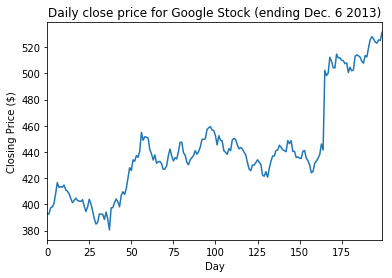

In [162]:
xlab = 'Day'
ylab = 'Closing Price ($)'
title = r'Daily close price for Google Stock (ending Dec. 6 2013)'

ax = google['value'].plot(title = title)
ax.set(xlabel=xlab, ylabel=ylab)
plt.show()

In [210]:
def naive(y, c):
    """
    y = df you want to provide a simple naive forecast on
    c = column for data
    """
    return y.loc[:,c].shift(1)

In [202]:
google.head()

,index,value
0,1,392.830017
1,2,392.512085
2,3,397.305908
3,4,398.011322
4,5,400.490204


In [206]:
c = 'value'
f = google.loc[:,c].shift(1)

In [211]:
google['naive'] = naive(google, 'value')

In [216]:
google['residuals'] = google['value']- google['naive'] 

In [217]:
google.head()

,index,value,naive,residuals
0,1,392.830017,NaN,NaN
1,2,392.512085,392.830017,-0.317932
2,3,397.305908,392.512085,4.793823
3,4,398.011322,397.305908,0.705414
4,5,400.490204,398.011322,2.478882


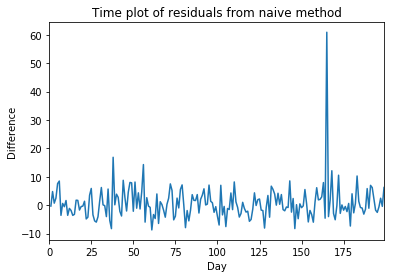

In [258]:
xlab = 'Day'
ylab = 'Difference'
title = r'Time plot of residuals from naive method'

ax = google['residuals'].plot(title = title)
ax.set(xlabel=xlab, ylabel=ylab)
plt.show()

In [223]:
import seaborn as sns

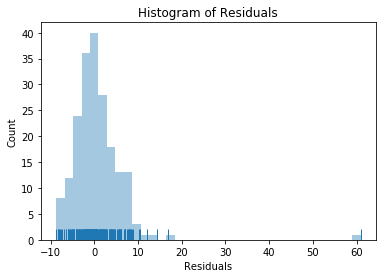

In [228]:
xlab = 'Residuals'
ylab = 'Count'
title = r'Histogram of Residuals'

ax = sns.distplot(google.loc[1:,'residuals'], kde=False, rug=True)
ax.set(xlabel=xlab, ylabel=ylab, title = title)

plt.show()

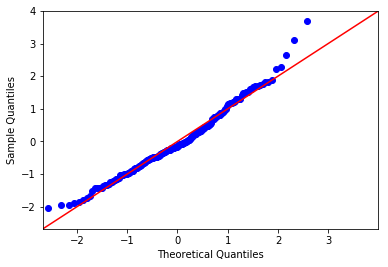

In [260]:
ax = sm.qqplot(google.loc[1:,'residuals'][google['residuals'].notnull() & (google['residuals'] != google['residuals'].max())], 
               stats.norm, 
               fit = True, 
               line='45')
ax.set_xlim = (-3,3)
plt.show()

### ACF of residuals

In [239]:
import statsmodels.api as sm

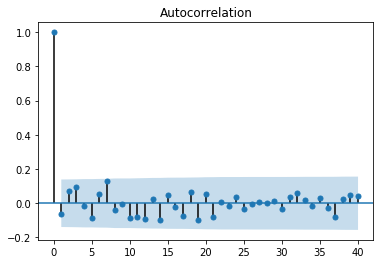

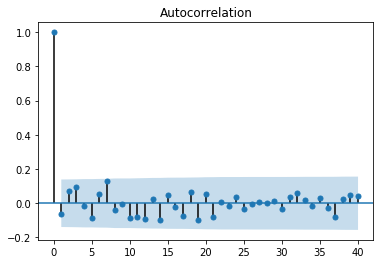

In [244]:
sm.graphics.tsa.plot_acf(google.loc[1:, 'residuals'], lags = 40)

#### Formal test for autocorrelation

### Summary:

Residuals are:

    1) Uncorrelated as shown in autocorrelation graph
    2) Average is close to zero
    3) Variance is mostly constant as shown in time plot
    4) Close but not normal as seen in histogram and QQ Plot